In [16]:
# Ahmet ÇÖLKESEN - Çağrı ÇAKIROĞLU

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Import custom modules
from person import Person
import dtale
from imblearn.over_sampling import SMOTE

# Import sklearn modules
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE

In [17]:
# Corrected file paths for the CSV files
csv_files = [
    'dataset/employee_survey_data.csv',
    'dataset/general_data.csv',
    'dataset/in_time.csv',
    'dataset/manager_survey_data.csv',
    'dataset/out_time.csv'
]

# Attempt to read each CSV file into a separate Pandas DataFrame
dataframes = {}
for file in csv_files:
    try:
        df_name = file.split('/')[-1].split('.')[0]  # Extract the name of the DataFrame from the file name
        dataframes[df_name] = pd.read_csv(file)
        print(f"Loaded {df_name} successfully.")
    except FileNotFoundError as e:
        print(f"Could not load {df_name}: {e}")

# List the names of the successfully loaded DataFrames
print("\nLoaded DataFrames:")
print("\n".join(dataframes.keys()))

Loaded employee_survey_data successfully.
Loaded general_data successfully.
Loaded in_time successfully.
Loaded manager_survey_data successfully.
Loaded out_time successfully.

Loaded DataFrames:
employee_survey_data
general_data
in_time
manager_survey_data
out_time


In [18]:
df = dataframes["general_data"]

df.insert(0, 'Emp_Id', range(1, len(df) + 1))

In [19]:
# Merging general_data and employee_survey_data
merged_df = pd.merge(dataframes["general_data"], 
                     dataframes["employee_survey_data"], 
                     left_on='Emp_Id', 
                     right_on='EmployeeID')

In [20]:
# Merging merged_df and manager_survey_data
merged_df = pd.merge(merged_df, 
                     dataframes["manager_survey_data"], 
                     left_on='Emp_Id', 
                     right_on='EmployeeID')

In [21]:
# Dropping unnecessary columns
merged_df = merged_df.drop(columns=["EmployeeID_x", "EmployeeID_y", "EmployeeID"])

## CHECKING NaN Values

In [22]:
# To check the number of NaN values in each column of the merged DataFrame
nan_counts = merged_df.isna().sum()

nan_counts[nan_counts > 0]  # Displaying the count of NaN values that are greater than 0

NumCompaniesWorked         19
TotalWorkingYears           9
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
dtype: int64

* There is total 110 NaN values, prefer to drop NA rows

In [23]:
# Dropping rows with NaN values from the merged DataFrame
merged_df_cleaned = merged_df.dropna()

# Optionally, you can check the number of rows before and after dropping NaN values
original_shape = merged_df.shape
cleaned_shape = merged_df_cleaned.shape

print("Original DataFrame shape:", original_shape)
print("DataFrame shape after dropping NaN rows:", cleaned_shape)

Original DataFrame shape: (4410, 29)
DataFrame shape after dropping NaN rows: (4300, 29)


## OUT TIME

In [26]:
df=dataframes["out_time"]
# Function to convert datetime to total seconds
def datetime_to_seconds(dt):
    if pd.isna(dt) or not isinstance(dt, pd.Timestamp):
        return dt  # If dt is NaN or already a number
    return dt.hour * 3600 + dt.minute * 60 + dt.second

def calculate_streaks_outliers_per_employee(diffs_from_mean):
    employee_results = {}
    for employee_id, diffs in diffs_from_mean.iterrows():
        Q1, Q3 = diffs.quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers and calculate streaks
        outliers = diffs[(diffs < lower_bound) | (diffs > upper_bound)]
        streaks = (outliers.notna() & outliers.shift().notna()).astype(int).cumsum()
        streak_counts = streaks[streaks != 0].value_counts()
        longest_streak = streak_counts.index.max() if not streak_counts.empty else 0

        employee_results[employee_id] = {'outlier_count': outliers.count(), 'longest_streak': longest_streak}
    return employee_results



# Convert all out times to total seconds
df_seconds = df.applymap(lambda x: datetime_to_seconds(pd.to_datetime(x, errors='coerce')))

# Calculate the average out time in seconds for each person
average_out_seconds = df_seconds.mean(axis=1)

# Replace NA values with the average out time in seconds for each person
df_seconds_filled = df_seconds.T.fillna(average_out_seconds).T

# Define quarter ranges
quarters = {'Q1': (1, 3), 'Q2': (4, 6), 'Q3': (7, 9), 'Q4': (10, 12)}

# Initialize dictionary to store quarterly streaks and outliers
quarterly_streaks_outliers = {}

for quarter, (start_month, end_month) in quarters.items():
    # Convert column names to datetime and extract months
    month_of_columns = pd.to_datetime(df_seconds_filled.columns, errors='coerce').month

    # Check if month is within the quarter range
    is_in_quarter = month_of_columns.isin(range(start_month, end_month + 1))

    # Ensure the boolean index aligns with the DataFrame columns
    if len(is_in_quarter) == df_seconds_filled.shape[1]:
        df_quarter = df_seconds_filled.loc[:, is_in_quarter]
        diffs_from_mean = df_quarter.sub(average_out_seconds, axis='index')

        # Calculate streaks and outliers for each employee
        quarterly_streaks_outliers[quarter] = calculate_streaks_outliers_per_employee(diffs_from_mean)
    else:
        # Handle the mismatch in lengths, if any
        print(f"Column length mismatch for quarter {quarter}")


C:\Users\acolk\AppData\Local\Temp\ipykernel_14480\336737250.py:45: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\acolk\AppData\Local\Temp\ipykernel_14480\336737250.py:45: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\acolk\AppData\Local\Temp\ipykernel_14480\336737250.py:45: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\acolk\AppData\Local\Temp\ipykernel_14480\336737250.py:45: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify

In [27]:
# Initialize a dictionary to hold the flattened data
flattened_data = {}

# Iterate over the data to flatten it
for quarter, employees in quarterly_streaks_outliers.items():
    for employee_id, data in employees.items():
        if employee_id not in flattened_data:
            flattened_data[employee_id] = {'Employee ID': employee_id}

        # Add the quarter-specific data
        #flattened_data[employee_id][f'{quarter}_Outlier'] = data['outlier_count']
        flattened_data[employee_id][f'{quarter}_Longest_Streak_OUT'] = data['longest_streak']

# Convert the flattened data into a DataFrame
results_df = pd.DataFrame.from_dict(flattened_data, orient='index')
results_df.head()

,Employee ID,Q1_Longest_Streak_OUT,Q2_Longest_Streak_OUT,Q3_Longest_Streak_OUT,Q4_Longest_Streak_OUT
0,0,0,0,0,0
1,1,0,2,0,0
2,2,0,0,0,3
3,3,1,0,0,0
4,4,0,2,0,1


## IN TIME

In [28]:
df=dataframes["in_time"]

# Convert all out times to total seconds
df_seconds = df.applymap(lambda x: datetime_to_seconds(pd.to_datetime(x, errors='coerce')))

# Calculate the average out time in seconds for each person
average_out_seconds = df_seconds.mean(axis=1)

# Replace NA values with the average out time in seconds for each person
df_seconds_filled = df_seconds.T.fillna(average_out_seconds).T

# Define quarter ranges
quarters = {'Q1': (1, 3), 'Q2': (4, 6), 'Q3': (7, 9), 'Q4': (10, 12)}

# Initialize dictionary to store quarterly streaks and outliers
quarterly_streaks_outliers = {}

for quarter, (start_month, end_month) in quarters.items():
    # Convert column names to datetime and extract months
    month_of_columns = pd.to_datetime(df_seconds_filled.columns, errors='coerce').month

    # Check if month is within the quarter range
    is_in_quarter = month_of_columns.isin(range(start_month, end_month + 1))

    # Ensure the boolean index aligns with the DataFrame columns
    if len(is_in_quarter) == df_seconds_filled.shape[1]:
        df_quarter = df_seconds_filled.loc[:, is_in_quarter]
        diffs_from_mean = df_quarter.sub(average_out_seconds, axis='index')

        # Calculate streaks and outliers for each employee
        quarterly_streaks_outliers[quarter] = calculate_streaks_outliers_per_employee(diffs_from_mean)
    else:
        # Handle the mismatch in lengths, if any
        print(f"Column length mismatch for quarter {quarter}")


C:\Users\acolk\AppData\Local\Temp\ipykernel_14480\1570600623.py:20: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\acolk\AppData\Local\Temp\ipykernel_14480\1570600623.py:20: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\acolk\AppData\Local\Temp\ipykernel_14480\1570600623.py:20: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\acolk\AppData\Local\Temp\ipykernel_14480\1570600623.py:20: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please spe

In [29]:
# Initialize a dictionary to hold the flattened data
flattened_data = {}

# Iterate over the data to flatten it
for quarter, employees in quarterly_streaks_outliers.items():
    for employee_id, data in employees.items():
        if employee_id not in flattened_data:
            flattened_data[employee_id] = {'Employee ID': employee_id}

        # Add the quarter-specific data
        #flattened_data[employee_id][f'{quarter}_Outlier'] = data['outlier_count']
        flattened_data[employee_id][f'{quarter}_Longest_Streak_IN'] = data['longest_streak']

# Convert the flattened data into a DataFrame
results_df_in = pd.DataFrame.from_dict(flattened_data, orient='index')
results_df_in.head()

,Employee ID,Q1_Longest_Streak_IN,Q2_Longest_Streak_IN,Q3_Longest_Streak_IN,Q4_Longest_Streak_IN
0,0,0,0,0,2
1,1,6,0,0,1
2,2,0,0,1,0
3,3,3,0,2,0
4,4,0,0,2,3


## MERGING

In [30]:
# Merging results_df and results_df_in on 'Employee ID'
merged_df2 = pd.merge(results_df, results_df_in, on='Employee ID', how='inner')
merged_df2.head()

,Employee ID,Q1_Longest_Streak_OUT,Q2_Longest_Streak_OUT,Q3_Longest_Streak_OUT,Q4_Longest_Streak_OUT,Q1_Longest_Streak_IN,Q2_Longest_Streak_IN,Q3_Longest_Streak_IN,Q4_Longest_Streak_IN
0,0,0,0,0,0,0,0,0,2
1,1,0,2,0,0,6,0,0,1
2,2,0,0,0,3,0,0,1,0
3,3,1,0,0,0,3,0,2,0
4,4,0,2,0,1,0,0,2,3


In [31]:
# Merging merged_df and merged_df2 on different employee ID columns
final_df = pd.merge(merged_df, merged_df2, left_on='Emp_Id', right_on='Employee ID', how='inner')

# Optionally, you might want to drop one of the duplicate employee ID columns after merging
# For example, if you want to drop 'employeeId' from merged_df2:
final_df = final_df.drop('Employee ID', axis=1)
final_df.head()

,Emp_Id,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,Gender,...,JobInvolvement,PerformanceRating,Q1_Longest_Streak_OUT,Q2_Longest_Streak_OUT,Q3_Longest_Streak_OUT,Q4_Longest_Streak_OUT,Q1_Longest_Streak_IN,Q2_Longest_Streak_IN,Q3_Longest_Streak_IN,Q4_Longest_Streak_IN
0,1,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,...,3,3,0,2,0,0,6,0,0,1
1,2,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,Female,...,2,4,0,0,0,3,0,0,1,0
2,3,32,No,Travel_Frequently,Research & Development,17,4,Other,1,Male,...,3,3,1,0,0,0,3,0,2,0
3,4,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,Male,...,2,3,0,2,0,1,0,0,2,3
4,5,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,Male,...,3,3,0,1,1,0,0,0,0,0


In [32]:
columns_to_encode = ['BusinessTravel',"Department","EducationField","Gender","JobRole","MaritalStatus"]

# Step 3: Apply one-hot encoding
encoded_df = pd.get_dummies(final_df, columns=columns_to_encode)

# Mapping "Yes" and "No" to 1 and 0 in the 'Attrition' column
encoded_df['Attrition'] = encoded_df['Attrition'].map({'Yes': 1, 'No': 0})

# Mapping "Y" and "N" to 1 and 0 in the 'Over18' column
encoded_df['Over18'] = encoded_df['Over18'].map({'Y': 1, 'N': 0})


encoded_df = encoded_df.dropna()

encoded_df = encoded_df.drop("StandardHours",axis=1)
encoded_df = encoded_df.drop("EmployeeCount",axis=1)
encoded_df = encoded_df.drop("Over18",axis=1)

In [33]:
# Splitting the DataFrame into features (X) and target (y)
X = encoded_df.drop('Attrition', axis=1)  # Drop the target column to create the feature set
y = encoded_df['Attrition']  # Target variable

In [34]:
d = dtale.show(encoded_df)

# Open the D-Tale interface in a new browser window or tab
d.open_browser()

## DATA VISUALIZATION

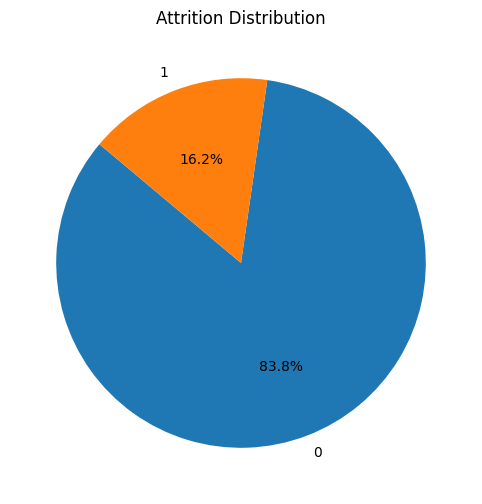

In [35]:
attrition_counts = encoded_df['Attrition'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(attrition_counts, labels=attrition_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Attrition Distribution')
plt.savefig('attrition_distribution.png')
plt.show()

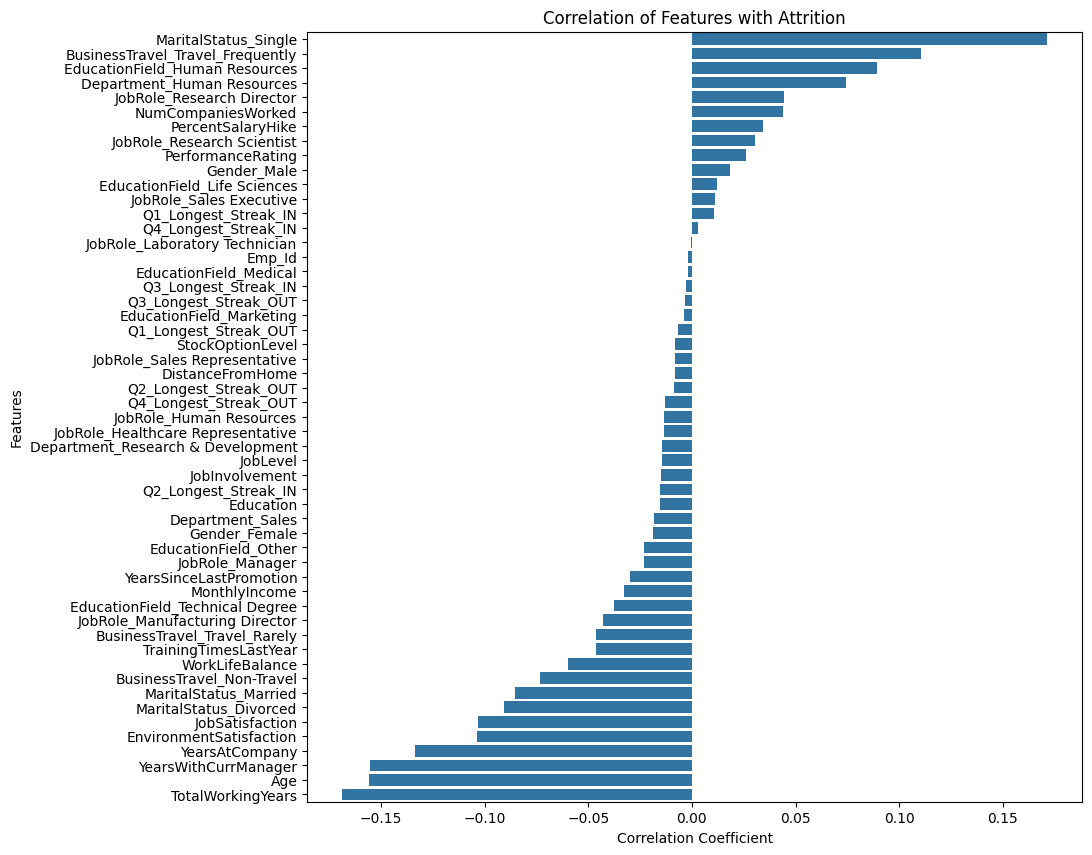

In [37]:
# Assuming 'merged_df' is your DataFrame and it has a column named 'Attrition'
# Calculate correlations with 'Attrition'
correlation_with_attrition = encoded_df.corr()['Attrition'].sort_values(ascending=False)

# Drop the 'Attrition' column itself from the correlation series
correlation_with_attrition = correlation_with_attrition.drop('Attrition', axis=0)

# Plotting
plt.figure(figsize=(10, 10))
sns.barplot(x=correlation_with_attrition, y=correlation_with_attrition.index)
plt.title('Correlation of Features with Attrition')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.savefig('feature_correlation_with_attrition.png')

plt.show()

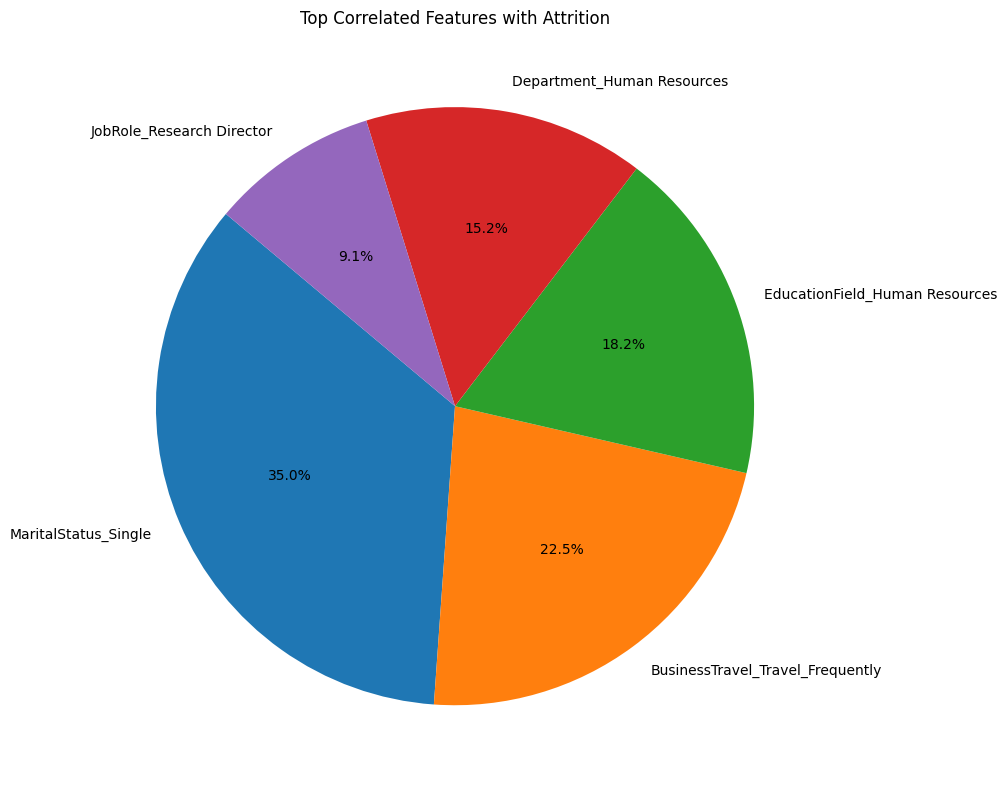

In [38]:
# Select the top N most correlated features
N = 5 
top_correlated_features = correlation_with_attrition.head(N)

plt.figure(figsize=(10, 8))
plt.pie(top_correlated_features, labels=top_correlated_features.index, autopct='%1.1f%%', startangle=140)
plt.title('Top Correlated Features with Attrition')
plt.tight_layout()

# Save the pie chart in a PNG file
plt.savefig('top_correlated_features_pie_chart.png', bbox_inches='tight')  # bbox_inches='tight' ensures the entire pie chart is saved

plt.show()

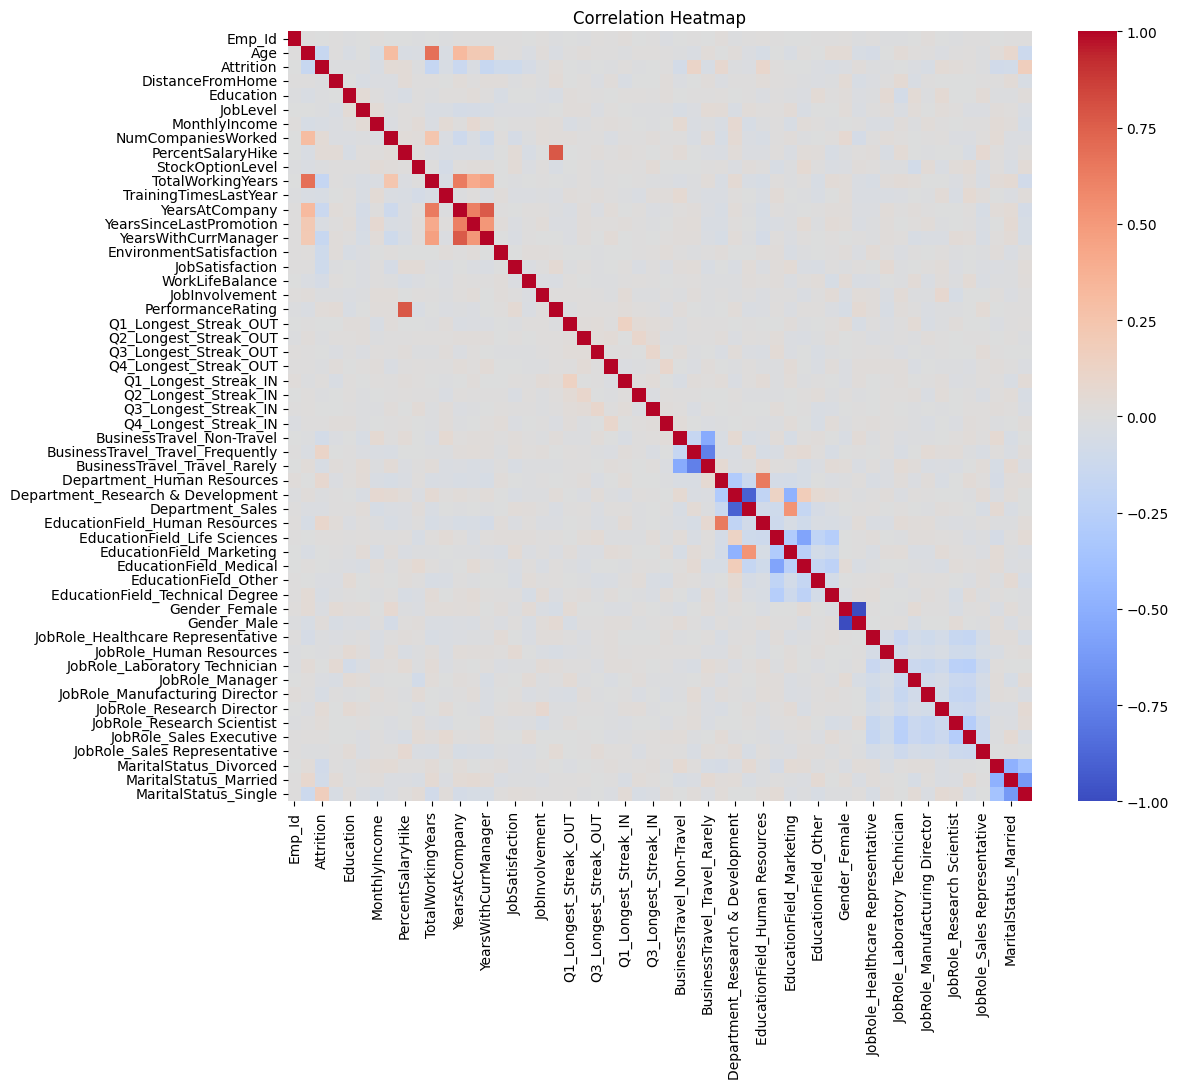

In [39]:
# Calculate the correlation matrix
corr_matrix = encoded_df.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')
plt.show()

## TRAIN- TEST SPLIT

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## PART 1 - LOGISTIC REGRESSION 

In [24]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Creating a pipeline with scaling, feature selection, and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', RFE(estimator=LogisticRegression(), n_features_to_select=10)),
    ('classifier', LogisticRegression())
])

# Hyperparameter tuning
parameters = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': [ 'l2']
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='roc_auc')
grid_search.fit(X_train_res, y_train_res)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('feature_selection',
                                        RFE(estimator=LogisticRegression(),
                                            n_features_to_select=10)),
                                       ('classifier', LogisticRegression())]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__penalty': ['l2']},
             scoring='roc_auc')

In [25]:
best_model = grid_search.best_estimator_

# Predictions
predictions = best_model.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
print("ROC AUC Score:", roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))

# Feature Importance
importance = best_model.named_steps['classifier'].coef_[0]
selected_features = best_model.named_steps['feature_selection'].support_

print("Feature Importance:")
for i, v in enumerate(importance):
    if selected_features[i]:
        print(f'Feature: {X.columns[i]}, Score: {v}')

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91       718
           1       0.52      0.10      0.17       142

    accuracy                           0.84       860
   macro avg       0.68      0.54      0.54       860
weighted avg       0.79      0.84      0.79       860

Confusion Matrix:
 [[705  13]
 [128  14]]
ROC AUC Score: 0.6587302365726392
Feature Importance:


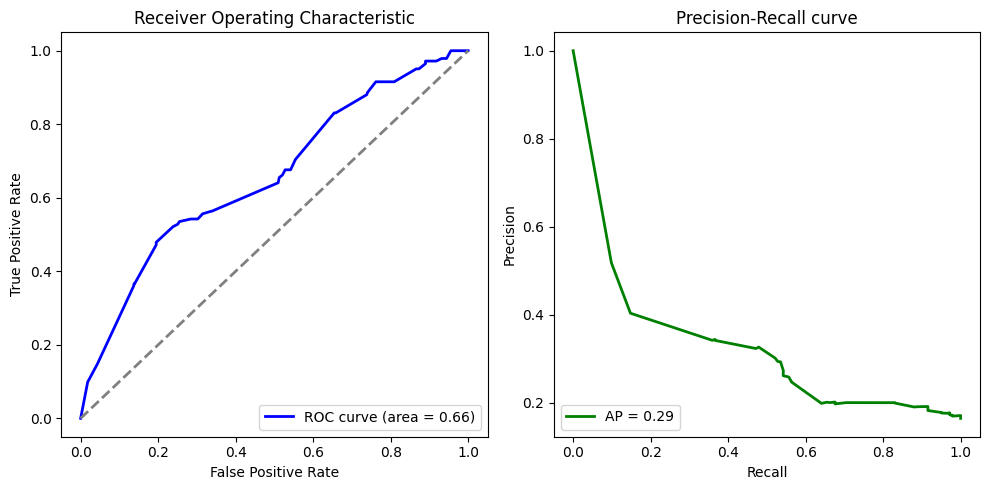

In [26]:
# Predicted probabilities
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

# Plot Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', lw=2, label=f'AP = {average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")

dir_path = 'logistic_regression_folder'  # Change this to your desired path
os.makedirs(dir_path, exist_ok=True)  # Create the directory if it does not exist

# Save the figure to the specified directory
plot_path = os.path.join(dir_path, 'logistic_regression_plots.png')
plt.savefig(plot_path)

plt.tight_layout()
plt.show()

## Decision Tree

In [28]:
# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creating and training the Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=0)
decision_tree_model.fit(X_train_scaled, y_train)

DecisionTreeClassifier(random_state=0)

Plots saved to decision_tree_folder/decision_tree_accuracy_plots.png
Accuracy: 0.95


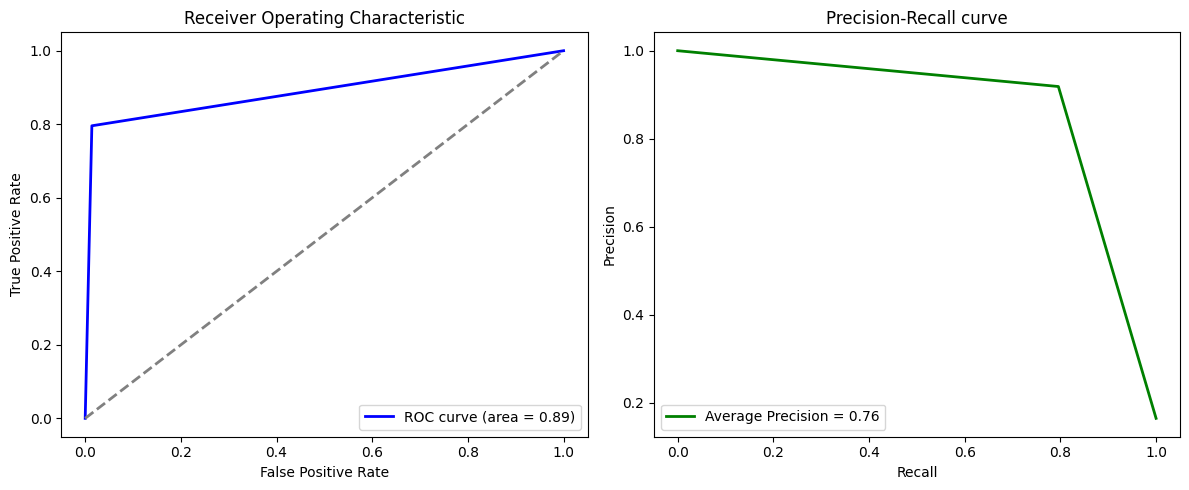

In [29]:
# Predicting probabilities
y_pred_proba = decision_tree_model.predict_proba(X_test_scaled)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

# Accuracy Score
accuracy = accuracy_score(y_test, decision_tree_model.predict(X_test_scaled))

# Plotting
plt.figure(figsize=(12, 5))

# ROC Curve Plot
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Precision-Recall Curve Plot
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', lw=2, label=f'Average Precision = {average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")

plt.tight_layout()

# Save the plots to a folder
dir_path = 'decision_tree_folder'  # Specify your folder path here
os.makedirs(dir_path, exist_ok=True)
plt.savefig(os.path.join(dir_path, 'decision_tree_accuracy_plots.png'))

# Print the path to the saved file
print(f"Plots saved to {os.path.join(dir_path, 'decision_tree_accuracy_plots.png')}")
print(f"Accuracy: {accuracy:.2f}")

## RANDOM FOREST

In [30]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

In [31]:
# Create the Random Forest model with GridSearchCV
rf_model = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Best model after grid search
best_rf_model = grid_search.best_estimator_

# Predictions
y_pred = best_rf_model.predict(X_test_scaled)
y_pred_proba = best_rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV

In [32]:
print(accuracy)

0.9790697674418605


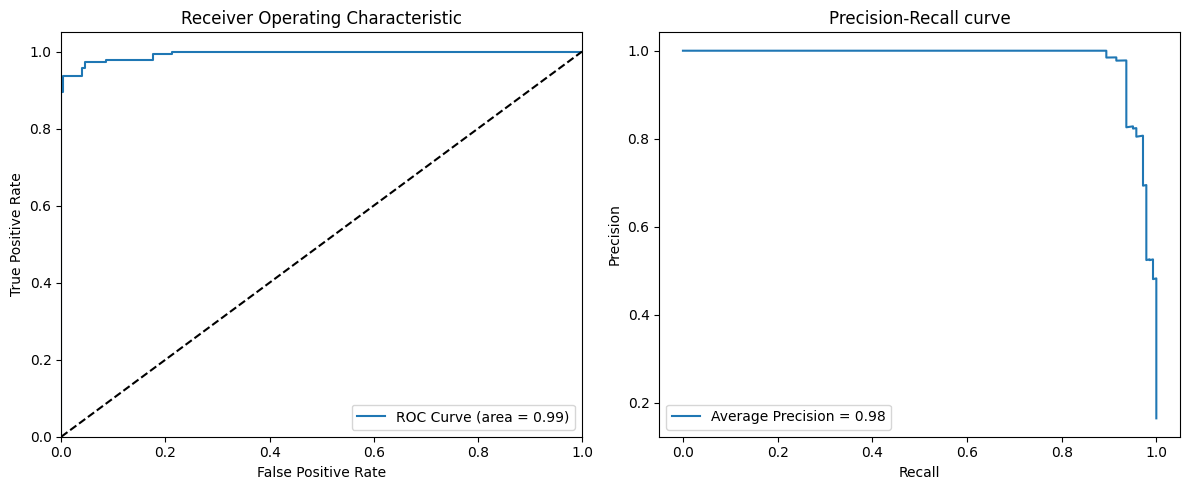

'RANDOM_FOREST/random_forest_performance_plots.png'

In [33]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

# Plotting
plt.figure(figsize=(12, 5))

# ROC Curve Plot
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Precision-Recall Curve Plot
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label='Average Precision = %0.2f' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")

plt.tight_layout()

# Save the plots to a folder
dir_path = 'RANDOM_FOREST'  # Change to your local path if not running in this environment
os.makedirs(dir_path, exist_ok=True)
plot_path = os.path.join(dir_path, 'random_forest_performance_plots.png')
plt.savefig(plot_path)
plt.show()

plt.close()

# Output the path to the saved plot
plot_path


## KNN AND WEIGHTED KNN 

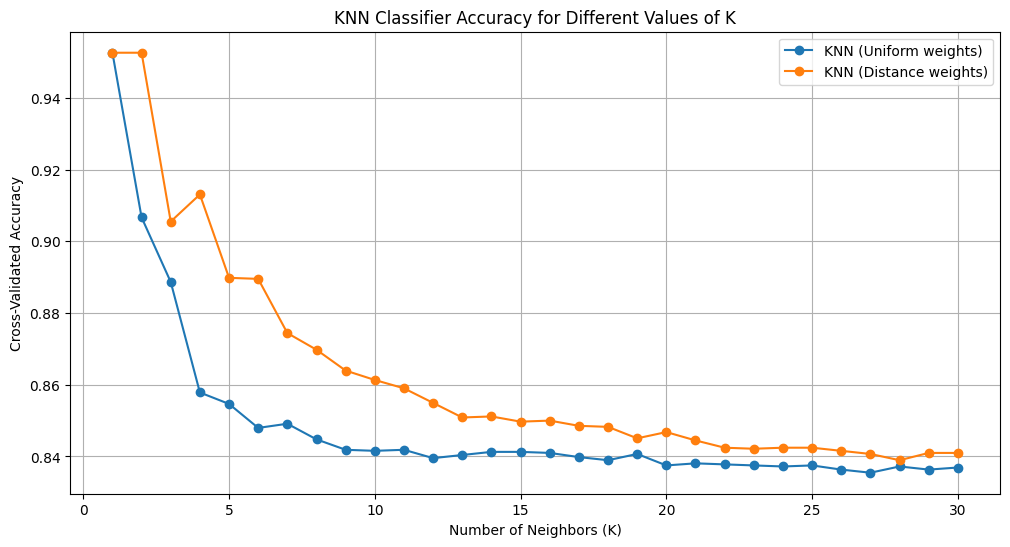

'KNN/knn_accuracy_comparison.png'

In [34]:
# Prepare to collect accuracy scores
avg_scores = []
avg_weighted_scores = []

# Range of k to try
K_values = range(1, 31)

# Try each value of k
for k in K_values:
    # KNN with uniform weights
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    avg_scores.append(np.mean(scores))

    # KNN with distance weights
    knn_weighted = KNeighborsClassifier(n_neighbors=k, weights='distance')
    weighted_scores = cross_val_score(knn_weighted, X_train_scaled, y_train, cv=5, scoring='accuracy')
    avg_weighted_scores.append(np.mean(weighted_scores))

# Plotting the accuracy for different values of K
plt.figure(figsize=(12, 6))
plt.plot(K_values, avg_scores, label='KNN (Uniform weights)', marker='o')
plt.plot(K_values, avg_weighted_scores, label='KNN (Distance weights)', marker='o')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN Classifier Accuracy for Different Values of K')
plt.legend()
plt.grid(True)

# Save the plot to a folder
dir_path = 'KNN'
os.makedirs(dir_path, exist_ok=True)
plot_path = os.path.join(dir_path, 'knn_accuracy_comparison.png')

plt.savefig(plot_path)
plt.show()
plt.close()

# Output the path to the saved plot
plot_path

In [35]:
# Choose the best K value (for uniform weights and distance weights)
best_k_uniform = K_values[np.argmax(avg_scores)]
best_k_distance = K_values[np.argmax(avg_weighted_scores)]

# Create KNN models with the best K values
knn_uniform = KNeighborsClassifier(n_neighbors=best_k_uniform, weights='uniform')
knn_distance = KNeighborsClassifier(n_neighbors=best_k_distance, weights='distance')

# Train the models
knn_uniform.fit(X_train_scaled, y_train)
knn_distance.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred_uniform = knn_uniform.predict(X_test_scaled)
y_pred_distance = knn_distance.predict(X_test_scaled)

# Calculate accuracy
accuracy_uniform = accuracy_score(y_test, y_pred_uniform)
accuracy_distance = accuracy_score(y_test, y_pred_distance)

# Print the accuracies
print(f"Accuracy with K={best_k_uniform} (Uniform weights): {accuracy_uniform:.2f}")
print(f"Accuracy with K={best_k_distance} (Distance weights): {accuracy_distance:.2f}")

Accuracy with K=1 (Uniform weights): 0.97
Accuracy with K=1 (Distance weights): 0.97


## NAIVE BAYES

In [36]:
# Step 1: Train the Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)

# Step 2: Make predictions
y_pred = gnb.predict(X_test_scaled)

# Step 3: Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

# Step 4: Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

# Step 5: Save the plot
dir_path = 'Naive_Bayes'
os.makedirs(dir_path, exist_ok=True)
cm_plot_path = os.path.join(dir_path, 'confusion_matrix.png')
plt.savefig(cm_plot_path)
plt.close()

# Print metrics and the path to the saved plot
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Saved confusion matrix plot at: {cm_plot_path}")

y_pred_prob = gnb.predict_proba(X_test_scaled)[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC (Area under the ROC Curve)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)

# Save the ROC curve plot
roc_plot_path = os.path.join(dir_path, 'roc_curve.png')
plt.savefig(roc_plot_path)
plt.close()

# Output the path to the saved ROC curve plot and AUC
print(f"ROC Curve saved at: {roc_plot_path}")
print(f"AUC: {roc_auc:.2f}")

Accuracy: 0.81
Precision: 0.80
Recall: 0.81
F1 Score: 0.80
Saved confusion matrix plot at: Naive_Bayes/confusion_matrix.png
ROC Curve saved at: Naive_Bayes/roc_curve.png
AUC: 0.71
